In [32]:
import pandas as pd
import math

# Data loading

In [33]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'target_x', 'target_y', 'target_z'])

# Load the Training/Test sets into pandas DataFrames
df_train : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TR.csv', delimiter=',')
df_test  : pd.DataFrame = data_handler.load_data(f'data/cup/ML-CUP23-TS.csv', delimiter=',')

# Print the head of the loaded data
print(df_train.head())
print(df_test.head())

   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.917280 -0.712727 -0.989904  0.992819  0.993649  0.995543  0.711074   
1   2 -0.858784  0.998755 -0.998396  0.999909  0.316503 -0.951897 -0.163139   
2   3 -0.990441  0.958726 -0.998675  0.997216  0.987166  0.356483 -0.279689   
3   4  0.937117  0.984474 -0.612420  0.999812  0.728623 -0.539962 -0.165939   
4   5 -0.906628 -0.884567 -0.932487  0.941037  0.978134  0.998179  0.749606   

       col8      col9     col10   target_x   target_y   target_z  
0  0.407645 -0.688548  0.616890   7.897453 -35.936382  21.077147  
1  0.980982  0.661759 -0.800155  -9.330632  19.901571   6.069154  
2  0.599163 -0.684630  0.922901  14.849400   3.374090  19.667479  
3  0.999352 -0.921444 -0.974766 -46.591854  13.734777  17.953600  
4 -0.590599 -0.508268  0.691798   8.217500 -45.885254  14.894251  
   id      col1      col2      col3      col4      col5      col6      col7  \
0   1 -0.983589  0.989514 -0.998539  0.99944

In [34]:
# Parameters' space for Grid Search (1 for each Dataset)

param_space = {

        'hidden_units': [65, 80], 
        'patience': [15, 30],
        'batch_size': [64, 128],
        'learning_rate': [0.03, 0.02], 
        'epochs': [650, 700],
        'weight_decay': [0.0002, 0.0001] ,
        'momentum': [0.7, 0.8],
        'activation': ['tanh'],
        'nesterov': [False],
        'output_activation': ['linear']    
}   



# Data Split

In [35]:
# Saving the ID columns
df_id_train: pd.DataFrame = df_train['id']
df_id_test: pd.DataFrame = df_test['id']

# Drop the ID columns
df_train = df_train.drop(columns=['id'],axis=1).copy(deep=True)
df_test = df_test.drop(columns=['id'],axis=1).copy(deep=True)

# Split of columns and rows (0.8/0.2) into: TR set and Internal TS set
x_train, y_train, x_internal_test, y_internal_test = data_handler.split_data(
    data=df_train,
    cols_name_split=['target_x','target_y','target_z'],
    rows_split_perc=0.8
)

# Split on columns
x_test, y_test = data_handler.split_data(data=df_test, cols_name_split=['target_x','target_y','target_z'])

# Print of the shapes
print(f"[IDs TR SET]: " + str(df_id_train.shape))
print(f"[IDs TS SET]: " + str(df_id_test.shape))
print(f"[TR SET - x]: " + str(x_train.shape))
print(f"[TR SET - y]: " + str(y_train.shape))
print(f"[Internal TS SET - x]: " + str(x_internal_test.shape))
print(f"[Internal TS SET - y]: " + str(y_internal_test.shape))
print(f"[TS SET - x]: " + str(x_test.shape))
print(f"[TS SET - y]: " + str(y_test.shape))

[IDs TR SET]: (1000,)
[IDs TS SET]: (900,)
[TR SET - x]: (800, 10)
[TR SET - y]: (800, 3)
[Internal TS SET - x]: (200, 10)
[Internal TS SET - y]: (200, 3)
[TS SET - x]: (900, 10)
[TS SET - y]: (900, 3)


# Model selection

## Best hyperparameters research

In [36]:
from sklearn.model_selection import KFold
from api.keras.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: BinaryNN = None

# Different values per dataset
trials = 100
k = 5

# Search of the best Hyperparameters
X = x_train.values.astype(dtype=float)
y = y_train.values.astype(dtype=float)

# K-fold Cross-validation
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Sets all the combinations of the entire set of parameters
data_handler.set_params_combinations(params=param_space)

# Gets the list with the combinations of all the parameters
params_combinations = data_handler.get_params_combinations()

# For each iteration we choose the hyperparameters and we use them with K-fold CV
for trial, params in enumerate(params_combinations):
#for trial in range(trials):

    # Choose random hyperparameters
    #params = data_handler.random_dictionary(params=param_space[0])

    # Creation of the Neural Network object
    nn_i = BinaryNN(params=params, monk_i=trial+1, trial=+1)

    nn_i.create_model(n_hidden_layers=2)
                    
    # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
    for train_index, val_index in kfold.split(X, y):
        x_kfold_train, x_kfold_val = X[train_index], X[val_index]
        y_kfold_train, y_kfold_val = y[train_index], y[val_index]

        nn_i.fit(
            x_train=x_kfold_train,
            y_train=y_kfold_train,
            x_val=x_kfold_val,
            y_val=y_kfold_val
        )

        nn_i.evaluate(
            x_train=x_kfold_train,
            y_train=y_kfold_train,
            x_val=x_kfold_val,
            y_val=y_kfold_val
        )

    # Case of first assignment
    if nn is None:
        nn = nn_i
    
    # Print the results of this trial
    print("\n------------------ Current Hyperparameters ------------------")
    nn_i.print_training_info()
    print("------------------ CUP Best Hyperparameters -----------------")
    nn.print_training_info()
    print("\n\n")

    # Update best hyperparameters if: no overfitting AND (higher mean VL accuracy OR (equal mean AND
    #if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy: #\
    #    and (
    #        nn.mean_vl_accuracy < nn_i.mean_vl_accuracy \
    #        or (
    #            nn.mean_vl_accuracy == nn_i.mean_vl_accuracy \
    #            and nn.mean_tr_accuracy < nn_i.mean_tr_accuracy
    #        )
    #    ):
        #nn = nn_i
    
    # Case of higher mean VL accuracy AND NO Overfitting
    if nn_i.mean_vl_accuracy < nn.mean_vl_accuracy and not math.isnan(nn_i.mean_vl_accuracy): 
        #\
        #and (
        #    abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < abs(nn.mean_tr_accuracy - nn.mean_vl_accuracy) \
        #    or abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02
        #):
        nn = nn_i
    
    # Exit case
    if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
        and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
        and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
        nn = nn_i
        break

# Print output
print(f"### Best Hyperparameters for CUP ###")
nn.print_training_info()
print("\n\n")



------------------ Current Hyperparameters ------------------
 Monk:                          1
 Trial:                         1
 Hyperparameters:               {'hidden_units': 65, 'patience': 15, 'batch_size': 64, 'learning_rate': 0.03, 'epochs': 650, 'weight_decay': 0.0002, 'momentum': 0.7, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
 Mean Training MSE:             0.23506244122982026
 Mean Validation MSE:           0.34898078739643096
 Mean Training MEE:             0.5724625587463379
 Mean Validation MEE:           0.6879557847976685
 Standard Deviation VL MEE:     0.16270216922685615
 Variance VL MEE:               0.02647199587112454
 Standard Deviation VL MEE:     0.22008884924573038
 Variance VL MEE:               0.048439101562309836

------------------ CUP Best Hyperparameters -----------------
 Monk:                          1
 Trial:                         1
 Hyperparameters:               {'hidden_units': 65, 'patience': 15, 'batch_size': 64


### Best Hyperparameters for CUP ###
 Monk:                          28
 Trial:                         1
 Hyperparameters:               {'hidden_units': 80, 'patience': 30, 'batch_size': 64, 'learning_rate': 0.02, 'epochs': 700, 'weight_decay': 0.0002, 'momentum': 0.7, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
 Mean Training MSE:             0.1330371230840683
 Mean Validation MSE:           0.20891327857971193
 Mean Training MEE:             0.38270283341407774
 Mean Validation MEE:           0.46904252767562865
 Standard Deviation VL MEE:     0.12672289466435216
 Variance VL MEE:               0.016058692032112493
 Standard Deviation VL MEE:     0.14996741568706448
 Variance VL MEE:               0.02249022576785679



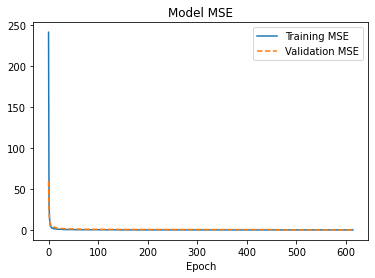

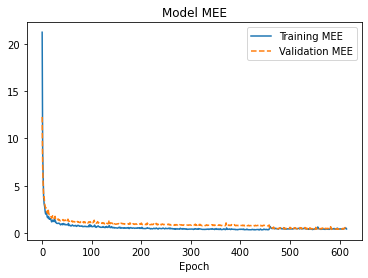

In [37]:
# Print best hyperparameters
print(f"\n### Best Hyperparameters for CUP ###")
nn.print_training_info()
nn.print_plot()


### Best Hyperparameters for CUP ###
#Monk:                          80
#Trial:                         1
#Hyperparameters:               {'hidden_units': 80, 'patience': 30, 'learning_rate': 0.03, 'batch_size': 64, 'epochs': 650, 'weight_decay': 0.0002, 'momentum': 0.7, 'activation': 'tanh', 'nesterov': False, 'output_activation': 'linear'}
#Mean Training MSE:             0.14155885428190232
#Mean Validation MSE:           0.2768428802490234
#Mean Training MEE:             0.36073383688926697
#Mean Validation MEE:           0.48465136885643006
#Standard Deviation VL MEE:     0.1676277815014571
#Variance VL MEE:               0.028099073131100244
#Standard Deviation VL MEE:     0.25346892754775996
#Variance VL MEE:               0.0642464972322116



# Model assessment

In [43]:
import keras.backend as K

X_test = x_internal_test.values
y_test = y_internal_test.values

score, y_pred = nn.predict(x_its=X_test, y_its=y_test)

# Final score
print("Mean Euclidean Error (Internal) test set:", round(K.eval(y_pred), 2))


r2_scores, average_r2 = nn.calculate_r2(y_test, y_pred)

print("R-squared for each variable:", r2_scores)
print("Average R-squared:", average_r2)

(200, 3)
